In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Replicate the classifier training and evaluation demonstrated in the example notebook Lab 4 - Comparison of Binary Classifiers.ipynb but with the dataset seeds.csv. 
- You will need to formulate a binary classification problem and transform the type column accordingly.
- Summarise your conclusions

In [4]:
df = pd.read_csv("./seeds.csv")
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

# Check for missing values

In [6]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

# Check for outliers

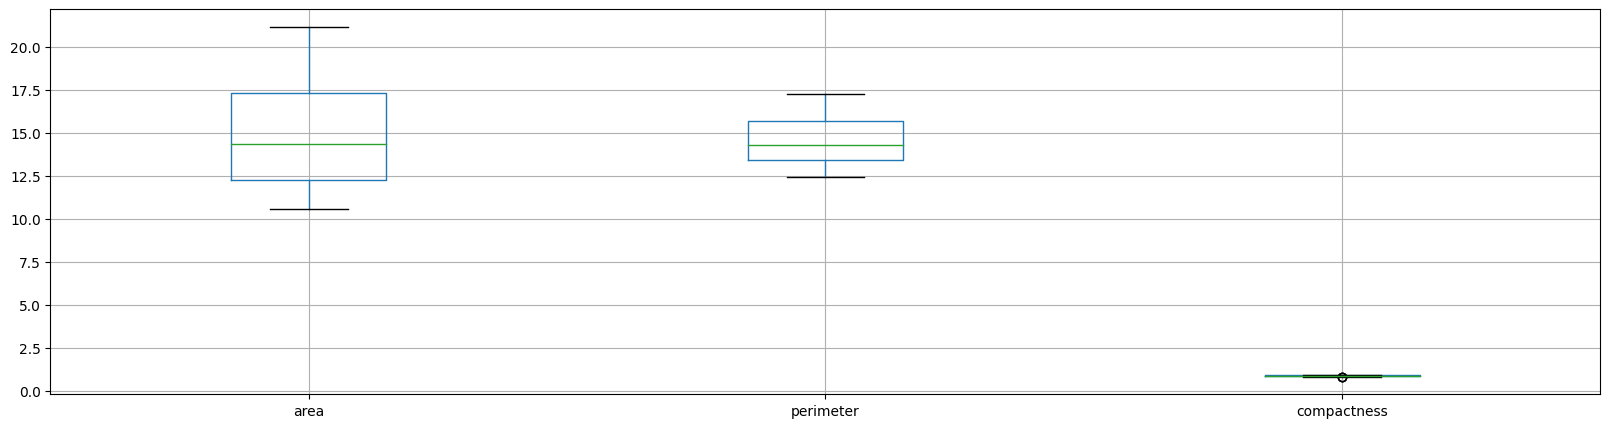

In [9]:
df.loc[:,'area':'compactness'].boxplot(figsize=(20,5))
plt.show()

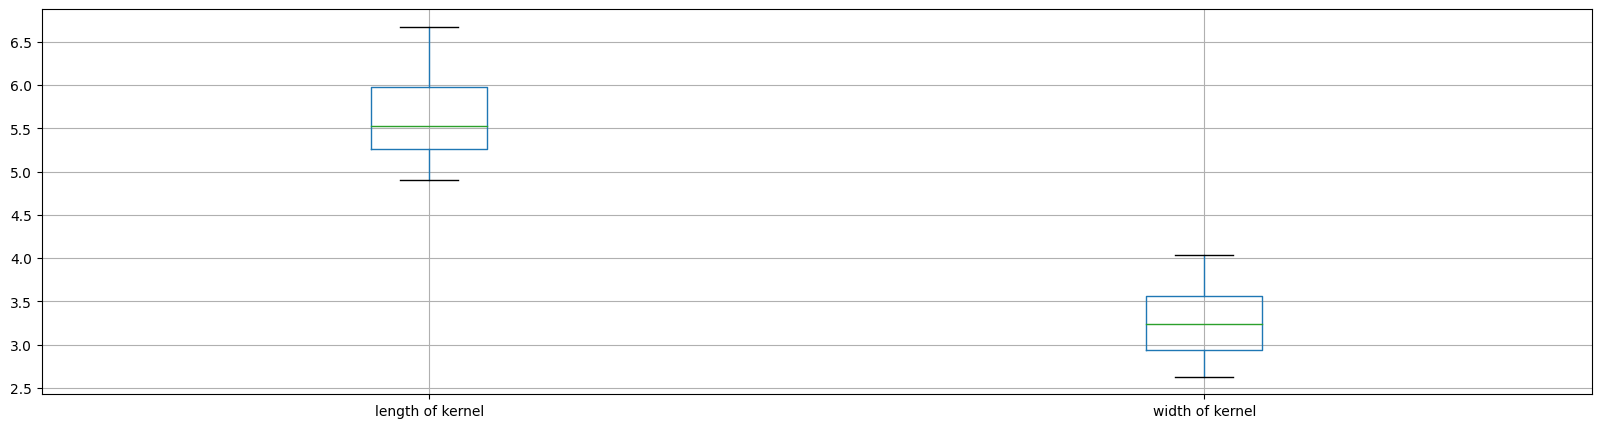

In [10]:
df.loc[:,'length of kernel':'width of kernel'].boxplot(figsize=(20,5))
plt.show()

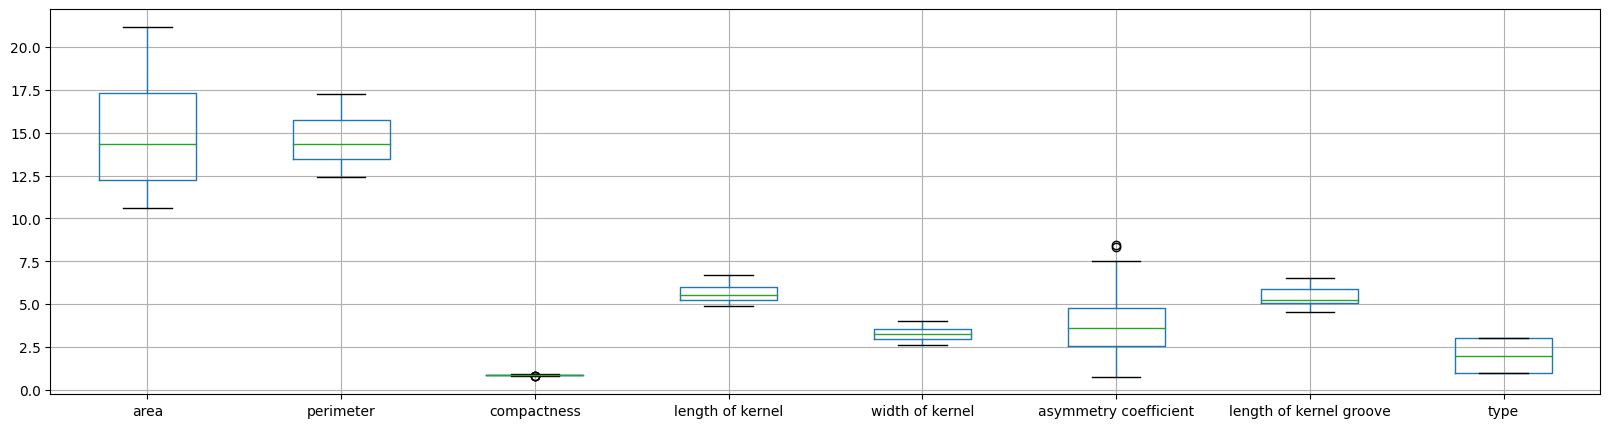

In [11]:
df.loc[:,'area':'type'].boxplot(figsize=(20,5))
plt.show()

# Outliers
- There seems to only be one dataset with outliers. this dataset is the asymmetry coefficient. 

# Remove outliers from list.

In [19]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

# Classes

In [20]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [21]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [22]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

# Splitting the data

In [23]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

# SVM

In [28]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times
#Julia

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.935:
Best parameters:  {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


# Random Forest

In [29]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
#param_grid = {
    #'rf__n_estimators' : [10,20,30],
    #'rf__max_depth': [2, 4, 6, 8]
#}

param_grid = {
    'rf__n_estimators' : [50, 100, 150],
    'rf__max_depth': [4, 6, 8, 10],
    
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.941:
Best parameters:  {'rf__max_depth': 6, 'rf__n_estimators': 50}


# Comparing the classifiers on a test set

# Old Code

In [30]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [38]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

#def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    #_probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
   # _predicted_values = model.predict(X_test)
        
    # compute accuracy
    #_accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    #_precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    #_fpr, _tpr, _ = roc_auc_score(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    #_tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    #_auc = auc(_fpr, _tpr)
            
    #return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [40]:
#SVM_accuracy = evaluate_model(X_test, y_test, SVM_best_model)
# RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

In [43]:

#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#def evaluate_model(X_test, y_test, model):
   # y_pred = model.predict(X_test)
    #accuracy = accuracy_score(y_test, y_pred)
    #precision = precision_score(y_test, y_pred, average=None)
    #recall = recall_score(y_test, y_pred, average=None)
    #f1_score = f1_score(y_test, y_pred, average=None)
    #auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
   # return accuracy, precision, recall, f1_score, auc

In [48]:
#SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
#RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_auc = evaluate_model(X_test, y_test, RF_best_model)


In [45]:
def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictions for the evaluation set
    _probabilities = model.predict_proba(X_test)
        
    # compuute exact predictions for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute AUC score for each class
    _auc = roc_auc_score(y_test, _probabilities, multi_class='ovr')
    
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _auc

In [46]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_auc = evaluate_model(X_test, y_test, RF_best_model)


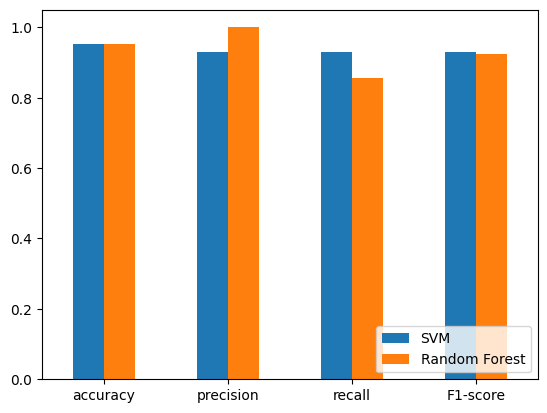

In [47]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

NameError: name 'SVM_tpr' is not defined

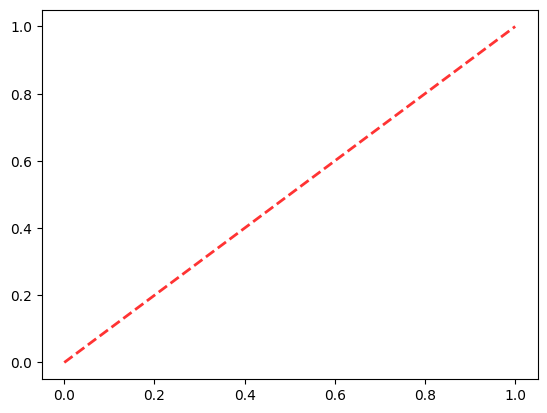

In [49]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

# Train Dataset

In [50]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

In [51]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))